In [34]:
%matplotlib ipympl
import os
import time
import pandas
import traceback
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from onix.helpers import present_float
from onix.models.schiff import inverse_fa_limit, axion_frequency_to_mass, axion_mass_to_frequency
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import scipy.constants as c
import allantools
from tqdm import tqdm
from uncertainties import ufloat, unumpy
from scipy.stats import pearsonr
from allantools import adev, mdev
from astropy.timeseries import LombScargle
from scipy.stats import norm
from onix.analysis.functions.lf_ramsey_shared import analyze_data
from onix.analysis.functions.lf_spectroscopy_quick_state_prep_axion import get_results
from onix.papers.axion_2024.lomb_scargle import frequency_sensitivity_from_experiment_times, ls_psd_to_power_spectrum
from onix.papers.axion_2024.axion_gluon_bounds import best_exp_bounds, worse_exp_bounds, model_dep_theory_bounds, model_indep_theory_bounds
from onix.papers.axion_2024.axion_gluon import S_Flambaum, S_Sushkov, S_geo_mean, E_xtl, theta_from_W_T

## long term phase scan

### data part 1

In [79]:
data_range = (4787037, 4787044)
first = data_range[0]
last = 5492916
results, col_indices = analyze_data(data_range, last, get_results, save_new=False)

You are attempting to analyze a subset of an already analyzed dataset. This has returned the larger dataset, not just the data numbers you asked for. Retry with load_old = False, save_new = False.
Existing data loaded


In [80]:
start_time_limit = 1722730400
end_time_limit = results[0, col_indices["start_time"]] + 757600
start_mask = (results[:, col_indices["start_time"]] > start_time_limit) & (results[:, col_indices["start_time"]] < end_time_limit)

data_spacing_time_upper_limit = 12
remove_data_points_before = 100
remove_data_points_after = 100
data_spacing_times = np.append(0, results[:, col_indices["start_time"]][1:] - results[:, col_indices["start_time"]][:-1])
data_spacing_times = data_spacing_times.astype(float)
data_spacing_time_discard_mask = data_spacing_times > data_spacing_time_upper_limit
data_spacing_time_mask = np.ones(len(results), dtype=bool)
for kk in data_spacing_time_discard_mask.nonzero()[0]:
    mask_last = kk + remove_data_points_after
    if mask_last > len(results):
        mask_last = len(results)
    data_spacing_time_mask[np.arange(kk - remove_data_points_before, mask_last)] = False

sigmas = 6
f_p = unumpy.nominal_values(results[:, col_indices["f+"]])
f_p_std = np.std(f_p)
f_p_avg = np.average(f_p)
f_p_mask = (f_p < f_p_std * sigmas + f_p_avg) & (f_p > -f_p_std * sigmas + f_p_avg)
f_m = unumpy.nominal_values(results[:, col_indices["f-"]])
f_m_std = np.std(f_m)
f_m_avg = np.average(f_m)
f_m_mask = (f_m < f_m_std * sigmas + f_m_avg) & (f_m > -f_m_std * sigmas + f_m_avg)
W_T = unumpy.nominal_values(results[:, col_indices["W_T"]])
W_T_std = np.std(W_T)
W_T_avg = np.average(W_T)
W_T_mask = (W_T < W_T_std * sigmas + W_T_avg) & (W_T > -W_T_std * sigmas + W_T_avg)

mask = start_mask & data_spacing_time_mask# & W_T_mask
print(len(results), np.sum(start_mask), np.sum(start_mask & data_spacing_time_mask), np.sum(mask))

start_times_1 = results[mask, col_indices["start_time"]].astype(float)
end_times_1 = results[mask, col_indices["end_time"]].astype(float)

Zs_1 = unumpy.nominal_values(results[mask, col_indices["Z"]])
W_Ts_1 = unumpy.nominal_values(results[mask, col_indices["W_T"]]) * np.sqrt(2.5 * 3.5)

98209 88258 77516 77516


### data part 2

In [271]:
data_range = (5679751, 5679758)
first = data_range[0]
last = 5736734
results, col_indices = analyze_data(data_range, last, get_results, save_new=False)

Existing data loaded


In [272]:
start_time_limit = results[0, col_indices["start_time"]] + 100
end_time_limit = results[0, col_indices["start_time"]] + 757600
start_mask = (results[:, col_indices["start_time"]] > start_time_limit) & (results[:, col_indices["start_time"]] < end_time_limit)

data_spacing_time_upper_limit = 10
remove_data_points_before = 100
remove_data_points_after = 100
data_spacing_times = np.append(0, results[:, col_indices["start_time"]][1:] - results[:, col_indices["start_time"]][:-1])
data_spacing_times = data_spacing_times.astype(float)
data_spacing_time_discard_mask = data_spacing_times > data_spacing_time_upper_limit
data_spacing_time_mask = np.ones(len(results), dtype=bool)
for kk in data_spacing_time_discard_mask.nonzero()[0]:
    mask_last = kk + remove_data_points_after
    if mask_last > len(results):
        mask_last = len(results)
    data_spacing_time_mask[np.arange(kk - remove_data_points_before, mask_last)] = False

sigmas = 6
f_p = unumpy.nominal_values(results[:, col_indices["f+"]])
f_p_std = np.std(f_p)
f_p_avg = np.average(f_p)
f_p_mask = (f_p < f_p_std * sigmas + f_p_avg) & (f_p > -f_p_std * sigmas + f_p_avg)
f_m = unumpy.nominal_values(results[:, col_indices["f-"]])
f_m_std = np.std(f_m)
f_m_avg = np.average(f_m)
f_m_mask = (f_m < f_m_std * sigmas + f_m_avg) & (f_m > -f_m_std * sigmas + f_m_avg)
W_T = unumpy.nominal_values(results[:, col_indices["W_T"]])
W_T_std = np.std(W_T)
W_T_avg = np.average(W_T)
W_T_mask = (W_T < W_T_std * sigmas + W_T_avg) & (W_T > -W_T_std * sigmas + W_T_avg)

mask = start_mask & data_spacing_time_mask# & W_T_mask
print(len(results), np.sum(start_mask), np.sum(start_mask & data_spacing_time_mask), np.sum(mask))

start_times_2 = results[mask, col_indices["start_time"]].astype(float)
end_times_2 = results[mask, col_indices["end_time"]].astype(float)

Zs_2 = unumpy.nominal_values(results[mask, col_indices["Z"]])
W_Ts_2 = unumpy.nominal_values(results[mask, col_indices["W_T"]]) * np.sqrt(2.5 * 3.5)

7123 7109 5521 5521


### combine

In [273]:
start_times = np.append(start_times_1, start_times_2)
end_times = np.append(end_times_1, end_times_2)
Zs = np.append(Zs_1, Zs_2)
W_Ts = np.append(W_Ts_1, W_Ts_2)

### analysis

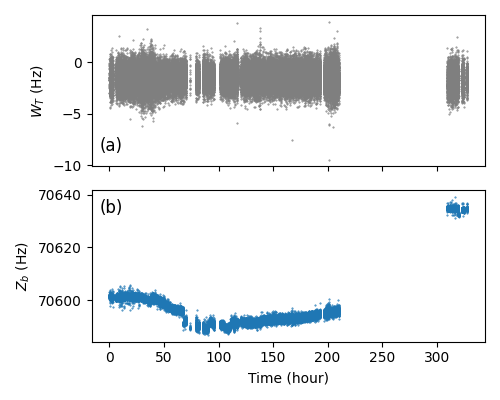

In [274]:
center_times = (start_times + end_times) / 2
center_time_offset = center_times[0]
center_time_offsetted = center_times - center_time_offset
center_time_offsetted_h = center_time_offsetted / 3600
cycle_times = end_times - start_times
num_of_cycles = len(start_times)
total_duration = end_times[-1] - start_times[0]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 4))
axs[1].set_ylabel("$Z_b$ (Hz)")
axs[0].set_ylabel("$W_T$ (Hz)")
axs[1].set_xlabel("Time (hour)")

axs[1].scatter(
    center_time_offsetted_h,
    Zs,
    color="C0",
    s=0.2,
    marker="o",
)
axs[0].text(0.02, 0.1, "(a)", transform=axs[0].transAxes, fontsize=12)
axs[0].scatter(
    center_time_offsetted_h,
    W_Ts,
    color="C7",
    s=0.2,
    marker="o",
)
axs[1].text(0.02, 0.85, "(b)", transform=axs[1].transAxes, fontsize=12)
#axs[0].set_xlim(np.min(center_time_offsetted_h), np.max(center_time_offsetted_h))
plt.tight_layout()
plt.savefig("time-series.png", dpi=300)
plt.show()

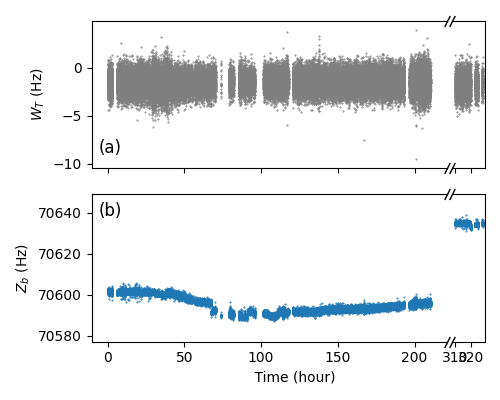

In [275]:
center_times = (start_times + end_times) / 2
center_time_offset = center_times[0]
center_time_offsetted = center_times - center_time_offset
center_time_offsetted_h = center_time_offsetted / 3600
cycle_times = end_times - start_times
num_of_cycles = len(start_times)
total_duration = end_times[-1] - start_times[0]

x_ratio = 11
fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(5, 4), width_ratios=(x_ratio, 1))
y_limits_Z_b = (np.min(Zs) - 10, np.max(Zs) + 10)
y_limits_W_T = (np.min(W_Ts) - 1, np.max(W_Ts) + 1)
break_center_time = 300
left_mask = center_time_offsetted_h < break_center_time
right_mask = center_time_offsetted_h > break_center_time
axs[1][0].set_ylabel("$Z_b$ (Hz)")
axs[0][0].set_ylabel("$W_T$ (Hz)")
axs[1][0].set_xlabel("            Time (hour)")
axs[1][0].scatter(
    center_time_offsetted_h[left_mask],
    Zs[left_mask],
    color="C0",
    s=0.2,
    marker="o",
)
axs[0][0].text(0.02, 0.1, "(a)", transform=axs[0][0].transAxes, fontsize=12)
axs[0][0].scatter(
    center_time_offsetted_h[left_mask],
    W_Ts[left_mask],
    color="C7",
    s=0.2,
    marker="o",
)
axs[1][0].text(0.02, 0.85, "(b)", transform=axs[1][0].transAxes, fontsize=12)
axs[1][1].scatter(
    center_time_offsetted_h[right_mask],
    Zs[right_mask],
    color="C0",
    s=0.2,
    marker="o",
)
axs[0][1].scatter(
    center_time_offsetted_h[right_mask],
    W_Ts[right_mask],
    color="C7",
    s=0.2,
    marker="o",
)
axs[0][0].set_xticklabels([])
axs[0][1].set_xticklabels([])
axs[0][0].set_ylim(*y_limits_W_T)
axs[0][1].set_ylim(*y_limits_W_T)
axs[1][0].set_ylim(*y_limits_Z_b)
axs[1][1].set_ylim(*y_limits_Z_b)
axs[0][1].set_yticklabels([])
axs[1][1].set_yticklabels([])
axs[0][0].spines["right"].set_visible(False)
axs[1][0].spines["right"].set_visible(False)
axs[0][1].set_yticks([])
axs[0][1].spines["left"].set_visible(False)
axs[1][1].set_yticks([])
axs[1][1].spines["left"].set_visible(False)
previous_xlim = axs[1][1].get_xlim()
left_xlim = axs[1][0].get_xlim()
left_xlim_range = left_xlim[1] - left_xlim[0]
xlim_center = (previous_xlim[0] + previous_xlim[1]) / 2
new_xlim_left = (-left_xlim_range / 2 / x_ratio + xlim_center, left_xlim_range / 2 / x_ratio + xlim_center)
axs[0][1].set_xlim(*new_xlim_left)
axs[1][1].set_xlim(*new_xlim_left)

d = 2  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
axs[0][0].plot([1, 1], [0, 1], transform=axs[0][0].transAxes, **kwargs)
axs[1][0].plot([1, 1], [0, 1], transform=axs[1][0].transAxes, **kwargs)
axs[0][1].plot([0, 0], [1, 0], transform=axs[0][1].transAxes, **kwargs)
axs[1][1].plot([0, 0], [1, 0], transform=axs[1][1].transAxes, **kwargs)

# TODO: tick on the right plots.

plt.tight_layout()
fig.subplots_adjust(wspace=0.03, )
plt.savefig("time-series.png", dpi=300)
plt.show()

In [276]:
cycle_time_avg = np.average(cycle_times)
cycle_frequency_avg = 1 / cycle_time_avg
W_T_unc = np.std(W_Ts) / np.sqrt(num_of_cycles)

print(f'#{first} - #{last}')
print(f"Time: {total_duration:.1f} s, N_cycle = {num_of_cycles}")
print(f"Cycle time (laser unlock time not included): {np.average(cycle_times):.2f} s, cycle frequency {cycle_frequency_avg:.2f} Hz")
print("W_T =", present_float(np.average(W_Ts * 1e3), W_T_unc * 1e3, 2), "mHz")
print(f"W_T_unc sensitivity = {W_T_unc * 1e3 / np.sqrt(3600 / total_duration):.1f} mHz sqrt(hr)")
print(f"W_T_unc per cycle = {W_T_unc * np.sqrt(num_of_cycles):.2f} Hz")

#5679751 - #5736734
Time: 1180597.1 s, N_cycle = 83037
Cycle time (laser unlock time not included): 6.75 s, cycle frequency 0.15 Hz
W_T = -1513.8(3.1) mHz
W_T_unc sensitivity = 55.6 mHz sqrt(hr)
W_T_unc per cycle = 0.88 Hz


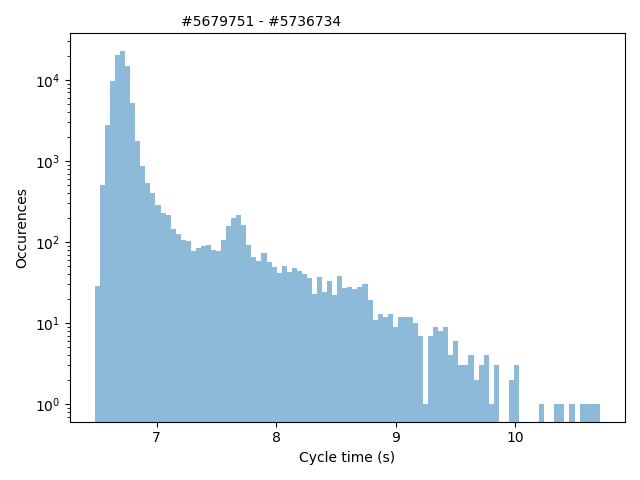

In [277]:
fig, ax = plt.subplots()
ax.text(0.2, 1.02, f'#{first} - #{last}', transform = ax.transAxes)
ax.hist(cycle_times, bins=100, alpha=0.5)
ax.set_xlabel("Cycle time (s)")
ax.set_ylabel("Occurences")
ax.set_yscale("log")
plt.tight_layout()
plt.show()

## cycle time simulation

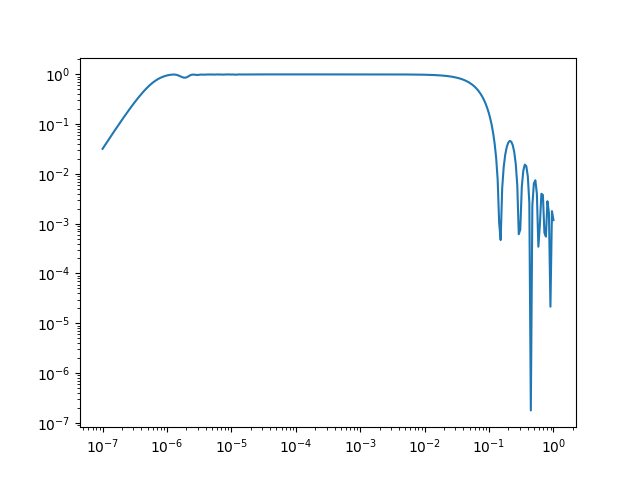

In [265]:
freqs_test = np.logspace(-7, 0, 300)
sensitivity_func = frequency_sensitivity_from_experiment_times(start_times, end_times, freqs_test)
fig, ax = plt.subplots()
ax.plot(freqs_test, sensitivity_func(freqs_test))
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

## analysis 08-12

In [278]:
ls = LombScargle(center_times, W_Ts, normalization="psd")

min_freq = 0.5 / total_duration
max_freq = 0.5 / cycle_time_avg
fs, f_W_T_psd = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
power_W_T = ls_psd_to_power_spectrum(f_W_T_psd, num_of_cycles)

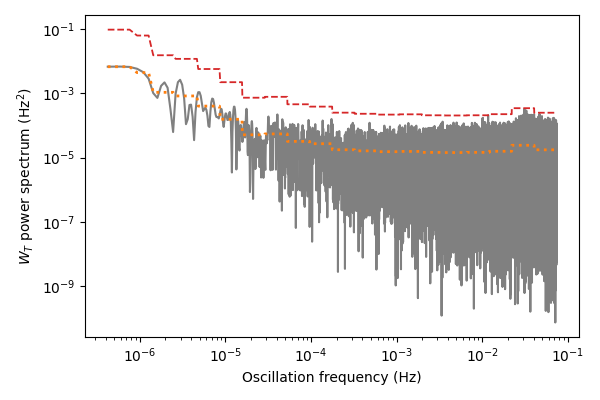

In [279]:
fs_bins = np.logspace(np.log10(np.min(fs) - 1e-10), np.log10(np.max(fs) + 1e-10), 20 + 1)
W_T_binned_indices = np.digitize(fs, fs_bins)
W_T_binned = []
for kk in range(1, len(fs_bins)):
    power_W_T_same_bin = power_W_T[W_T_binned_indices==kk]
    W_T_binned.extend([np.average(power_W_T_same_bin)] * len(power_W_T_same_bin))
W_T_binned = np.array(W_T_binned)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fs, power_W_T, label="data", color="gray")
ax.plot(fs, W_T_binned, label="binned average", color="C1", ls="dotted", linewidth=2)
global_95_bound = -np.log(1 - 0.95 ** (1/num_of_cycles)) * W_T_binned
ax.plot(fs, global_95_bound, label=f"95% confidence level", color="C3", linewidth=1.3, ls="dashed")
ax.set_ylabel("$W_T$ power spectrum (Hz$^2$)")
ax.set_xlabel("Oscillation frequency (Hz)")
ax.set_xscale("log")
ax.set_yscale("log")
#ax.legend()
plt.tight_layout()
plt.savefig("spectrum.pdf")
plt.show()

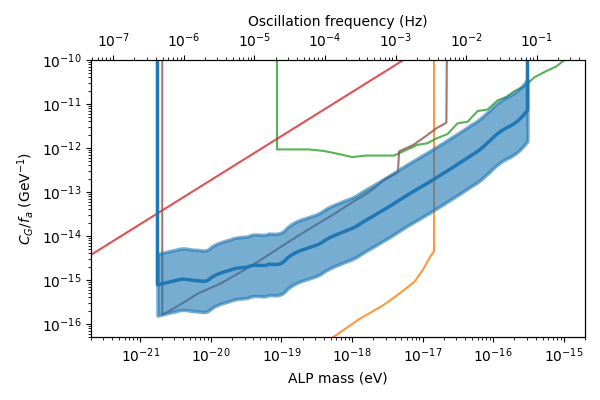

In [280]:
W_T_bound = np.sqrt(global_95_bound * 2 / sensitivity_func(fs)) / np.sqrt(2.5 * 3.5)
fs_log = np.logspace(np.log10(np.min(fs) + 1e-12), np.log10(np.max(fs) - 1e-12), 100000)

W_T_bound_log = interp1d(fs, W_T_bound)(fs_log)
W_T_bound_log = savgol_filter(W_T_bound_log, 10000, 3)
theta_bound_Flambaum = theta_from_W_T(W_T_bound_log, S_Flambaum, E_xtl)
theta_bound_Sushkov = theta_from_W_T(W_T_bound_log, S_Sushkov, E_xtl)
theta_bound_geo_mean = theta_from_W_T(W_T_bound_log, S_geo_mean, E_xtl)

stochastic_factor = 3
inverse_fa_bound_Flambaum = inverse_fa_limit(fs_log, theta_bound_Flambaum) * stochastic_factor
inverse_fa_bound_Sushkov = inverse_fa_limit(fs_log, theta_bound_Sushkov) * stochastic_factor
inverse_fa_bound_geo_mean = inverse_fa_limit(fs_log, theta_bound_geo_mean) * stochastic_factor

masses = axion_frequency_to_mass(fs_log)
fig, ax = plt.subplots(figsize=(6, 4))
ax1 = ax.twiny()
counter = 1
for kk in best_exp_bounds:
    temp_x = best_exp_bounds[kk][0]
    temp_y = best_exp_bounds[kk][1]
    #ax.fill_between(temp_x, temp_y, 1, alpha=0.2, zorder=counter, color=f"C{counter}")
    temp_x = np.append([temp_x[0]], temp_x)
    temp_y = np.append([1], temp_y)
    temp_x = np.append(temp_x, [temp_x[-1]])
    temp_y = np.append(temp_y, [1])
    ax.plot(temp_x, temp_y, label=kk, alpha=0.8, zorder=counter, color=f"C{counter}")
    counter += 1
    if counter == 1:
        counter += 1
for kk in worse_exp_bounds:
    temp_x = worse_exp_bounds[kk][0]
    temp_y = worse_exp_bounds[kk][1]
    #ax.fill_between(temp_x, temp_y, 1, alpha=0.2, zorder=counter, color=f"C7")
    temp_x = np.append([temp_x[0]], temp_x)
    temp_y = np.append([1], temp_y)
    temp_x = np.append(temp_x, [temp_x[-1]])
    temp_y = np.append(temp_y, [1])
    ax.plot(temp_x, temp_y, label=kk, alpha=0.8, zorder=counter, color=f"C{counter}")
    counter += 1
    if counter == 1 or counter == 4:
        counter += 1
for kk in model_indep_theory_bounds:
    temp_x = model_indep_theory_bounds[kk][0]
    temp_y = model_indep_theory_bounds[kk][1]
    #ax.fill_between(temp_x, temp_y, 1, alpha=0.2, zorder=counter, color=f"C6")
    temp_x = np.append([temp_x[0]], temp_x)
    temp_y = np.append([1], temp_y)
    temp_x = np.append(temp_x, [temp_x[-1]])
    temp_y = np.append(temp_y, [1])
    ax.plot(temp_x, temp_y, label=kk, alpha=0.8, zorder=counter, color=f"C6")
    counter += 1
    if counter == 1:
        counter += 1
#ax.fill_between(masses, inverse_fa_bound_Sushkov, 1, zorder=counter, color="gray", alpha=0.6)
#ax.fill_between(masses, inverse_fa_bound_Flambaum, 1, zorder=counter, color="gray", alpha=0.6)
ax.fill_between(masses, inverse_fa_bound_Flambaum, inverse_fa_bound_Sushkov, zorder=counter, color="C0", alpha=0.6,  linewidth=2.5)
ax.plot(
    np.append(np.append(masses[0], masses), masses[-1]),
    np.append(np.append(1, inverse_fa_bound_geo_mean), 1),
    color="C0", label="Eu:YSO (this work)", zorder=counter, alpha=1, linewidth=2.5,
)
# ax.plot(
#     np.append(np.append(masses[0], masses), masses[-1]),
#     np.append(np.append(1, inverse_fa_bound_geo_mean), 1),
#     color="k", label="Eu:YSO (this work)", zorder=counter, alpha=1
# )
# ax.plot(
#     masses,
#     inverse_fa_bound_geo_mean,
#     color="k", label="Eu:YSO (this work)", zorder=counter, alpha=1, linewidth=2.5,
# )
# ax.plot(
#     np.append(np.append(masses[0], masses), masses[-1]),
#     np.append(np.append(1, inverse_fa_bound_Flambaum), 1),
#     color="k", label="Eu:YSO (this work)", zorder=counter, alpha=1, linewidth=0.5
# )
ax.set_ylabel("$C_G / f_a$ (GeV${}^{-1}$)")
ax.set_xlabel("ALP mass (eV)")
ax1.set_xscale("log")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(0.5e-16, 1e-10)
#ax.set_xticks([1e-22, 1e-21, 1e-18, 1e-15, 1e-12])
ax.set_xlim(2e-22, 2e-15)
ax1.set_xlim(axion_mass_to_frequency(2e-22), axion_mass_to_frequency(2e-15))
#ax1.set_xticks([1e-9, 1e-7, 1e-5, 1e-3, 0.1, 10, 1000])
ax1.set_xlabel("Oscillation frequency (Hz)")
#ax.legend()
plt.tight_layout()
plt.savefig("exclusion.pdf")
plt.show()

## numbers

In [143]:
theta_from_W_T(269.752e3, 1, 1)

1.0000009110215744

In [144]:
print(np.min(fs), np.max(fs), len(fs))

4.495650697402306e-07 0.0739752087843329 411367
